# Imports

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

import scipy.optimize as sopt

tf.random.set_seed(1)

import numpy as np
from scipy.interpolate import griddata
import time
from pyDOE import lhs
import datetime

import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib widget

# Meta

In [2]:
__NAME = 'Heat_1'
__CLASS = 'Heat_Eqn'
__CACHE = None

In [35]:
__MODEL = "FFD"
# __MODEL = "Residual"

# Equation

In [36]:
k = 1
L = 5

$$
\frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2}
$$

# Prepare data

In [37]:
# x : t
# y : x

In [38]:
lb = np.array([0.0  , 0.0])
ub = np.array([10.0 , 5.0])

N_x = 400               # t
N_y = 200               # x
N_f = 20000             # Area
print(N_x, N_y, N_f)

x_data = np.linspace(lb[0], ub[0], N_x)[:, None]
y_data = np.linspace(lb[1], ub[1], N_y)[:, None]

400 200 20000


In [39]:
X_sol, Y_sol = np.meshgrid(x_data, y_data)

U_sol = np.hstack(
    (X_sol.flatten()[:, None], Y_sol.flatten()[:, None])
    )
# U_sol_star = U_sol.flatten()[:, None]

print(U_sol.shape, U_sol[0:10], sep='\n')

(80000, 2)
[[0.         0.        ]
 [0.02506266 0.        ]
 [0.05012531 0.        ]
 [0.07518797 0.        ]
 [0.10025063 0.        ]
 [0.12531328 0.        ]
 [0.15037594 0.        ]
 [0.1754386  0.        ]
 [0.20050125 0.        ]
 [0.22556391 0.        ]]


In [40]:
X_lb = np.hstack((X_sol[:, 0:1], Y_sol[:, 0:1]))        # left boundary
U_X_lb = (6 * np.sin(np.pi * y_data / L))

Y_lb = np.hstack((X_sol[0:1, :].T, Y_sol[0:1, :].T))    # lower boundary
U_Y_lb = np.repeat([[0]], N_x, axis=0)

Y_rb = np.hstack((X_sol[-1:, :].T, Y_sol[-1:, :].T))    # upper boundary
U_Y_rb = np.repeat([[0]], N_x, axis=0)

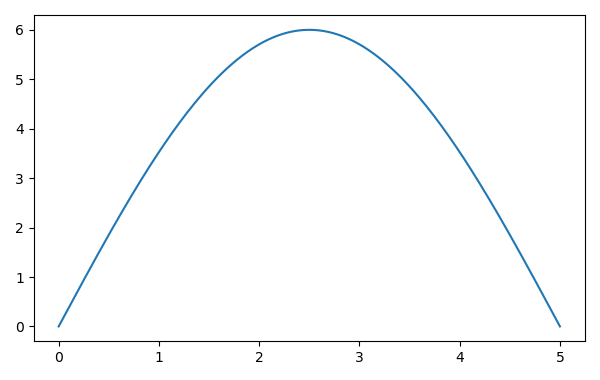

In [41]:
fig = plt.figure(figsize=( 6, 3.8))
ax1 = fig.subplots()

ax1.plot(X_lb[:, 1], U_X_lb[:, 0])

fig.tight_layout()

In [42]:
# shuffle boundary data
idx_X_lb = np.random.choice(y_data.shape[0], N_y, replace=False)
idx_Y_lb = np.random.choice(x_data.shape[0], N_x, replace=False)

X_lb = X_lb[idx_X_lb, :]

Y_lb = Y_lb[idx_Y_lb, :]
Y_rb = Y_rb[idx_Y_lb, :]

U_X_lb = U_X_lb[idx_X_lb, :]

U_Y_lb = U_Y_lb[idx_Y_lb, :]
U_Y_rb = U_Y_rb[idx_Y_lb, :]

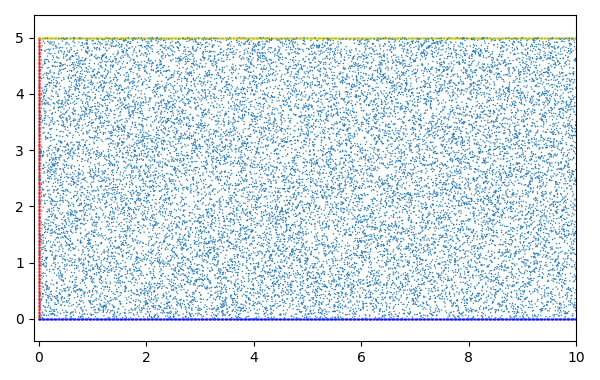

In [43]:
# lhs Sampling for the given domain
I_f = lb + (ub - lb) * lhs(2, N_f)

#-------------------------------------------------------------------------------
fig = plt.figure(figsize=(6, 3.8))
ax = fig.gca()

ax.set_xlim(lb[0] -0.1, ub[0])
ax.set_ylim(lb[1] - 0.4, ub[1] + 0.4)

ax.scatter(X_lb[:, 0], X_lb[:, 1], s=1, c='r', marker='.', label='X_lb')
ax.scatter(Y_lb[:, 0], Y_lb[:, 1], s=1, c='b', marker='.', label='Y_lb')
ax.scatter(Y_rb[:, 0], Y_rb[:, 1], s=1, c='y', marker='.', label='Y_rb')

ax.scatter(I_f[:, 0], I_f[:, 1], s=4, marker='.', edgecolors='none')
fig.tight_layout()

# Model

In [44]:
class HiddenLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, units) -> None:
        super(HiddenLayer, self).__init__()
        xavier_stddev = np.sqrt(2 / (input_dim + units))
        w_init = tf.initializers.TruncatedNormal(stddev=xavier_stddev)
        self.w = tf.Variable(initial_value= w_init(shape= (input_dim, units), dtype= tf.float32), trainable= True)

        b_init = tf.zeros_initializer()
        self.b = tf.Variable(initial_value= b_init(shape= (1, units), dtype= tf.float32), trainable= True)

    def call(self, x):
        return tf.matmul(x, self.w) + self.b

In [45]:
class MySuperClass(tf.keras.Model):
    def __init__(self) -> None:
        super(MySuperClass, self).__init__()

    def initStitches(self):
        self.shapes = tf.shape_n(self.trainable_variables)
        self.n_tensors = len(self.shapes)

        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        self.count = 0
        self.idx = [] # stitch indices
        self.part = [] # partition indices

        for i, shape in enumerate(self.shapes):
            n = np.product(shape)
            self.idx.append(tf.reshape(tf.range(self.count, self.count+n, dtype=tf.int32), shape))
            self.part.extend([i] * n)
            self.count += n

        self.part = tf.constant(self.part)

    def update(self, x : tf.Tensor):
        params = tf.dynamic_partition(x, self.part, self.n_tensors)
        for i, (shape, param) in enumerate(zip(self.shapes, params)):
            self.trainable_variables[i].assign(tf.reshape(param, shape))

In [46]:
class FeedForwardModel(MySuperClass):
    def __init__(self) -> None:
        super(FeedForwardModel, self).__init__()

        self.HLayer_1 = HiddenLayer(2, 50)
        self.HLayer_2 = HiddenLayer(50, 50)
        self.HLayer_3 = HiddenLayer(50, 50)
        self.HLayer_4 = HiddenLayer(50, 50)
        self.HLayer_5 = HiddenLayer(50, 50)
        self.HLayer_6 = HiddenLayer(50, 1)

        self.initStitches()

    def call(self, x):
        x = self.HLayer_1(x)
        x = tf.sin(x)
        x = self.HLayer_2(x)
        x = tf.sin(x)
        x = self.HLayer_3(x)
        x = tf.sin(x)
        x = self.HLayer_4(x)
        x = tf.sin(x)
        x = self.HLayer_5(x)
        x = tf.sin(x)
        x = self.HLayer_6(x)
        return x

In [47]:
class ResidualModel(MySuperClass):
    def __init__(self) -> None:
        super(ResidualModel, self).__init__()

        self.HLayer_1 = HiddenLayer(2, 50)
        self.HLayer_2 = HiddenLayer(50, 50)
        self.HLayer_3 = HiddenLayer(50, 50)
        self.HLayer_4 = HiddenLayer(50, 50)
        self.HLayer_5 = HiddenLayer(50, 50)
        self.HLayer_6 = HiddenLayer(50, 1)

        self.initStitches()

    def call(self, x):
        x = self.HLayer_1(x)
        x = tf.sin(x)

        x2 = x

        x = self.HLayer_2(x)

        x = x + x2
        x = tf.sin(x)
        x = self.HLayer_3(x)

        x = x + x2
        x = tf.sin(x)
        x = self.HLayer_4(x)

        x = x + x2
        x = tf.sin(x)
        x = self.HLayer_5(x)

        x = x + x2

        x = tf.sin(x)
        x = self.HLayer_6(x)
        return x

In [48]:
# Create an instance of the model
if (__MODEL == "FFD"):
    model = FeedForwardModel()
elif (__MODEL == "Residual"):
    model = ResidualModel()

# test
# x = tf.convert_to_tensor([[2.0, 0.0]])
# model(x)

In [49]:
if (__CACHE is None):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    __CACHE = tf.dynamic_stitch(model.idx, model.trainable_variables)
else:
    model.update(__CACHE)

## Training functions

In [50]:
lb_tf = tf.convert_to_tensor(lb, dtype=tf.float32)
ub_tf = tf.convert_to_tensor(ub, dtype=tf.float32)

X_lb_x_tf = tf.Variable(X_lb[:, 0:1], dtype=tf.float32)
X_lb_y_tf = tf.Variable(X_lb[:, 1:2], dtype=tf.float32)
U_X_lb_tf = tf.Variable(U_X_lb, dtype=tf.float32)

Y_lb_x_tf = tf.Variable(Y_lb[:, 0:1], dtype=tf.float32)
Y_lb_y_tf = tf.Variable(Y_lb[:, 1:2], dtype=tf.float32)
U_Y_lb_tf = tf.Variable(U_Y_lb, dtype=tf.float32)

Y_rb_x_tf = tf.Variable(Y_rb[:, 0:1], dtype=tf.float32)
Y_rb_y_tf = tf.Variable(Y_rb[:, 1:2], dtype=tf.float32)
U_Y_rb_tf = tf.Variable(U_Y_rb, dtype=tf.float32)

x_f_tf = tf.Variable(I_f[:, 0:1], dtype=tf.float32)
y_f_tf = tf.Variable(I_f[:, 1:2], dtype=tf.float32)

In [51]:
def sol_net(x, y):
    print("Tracing sol_net")

    X = tf.concat([x, y], 1)
    H = 2.0 * (X - lb_tf) / (ub_tf - lb_tf) - 1.0
    u = model(H)
    return u

In [52]:
def sol_net_eqn(x, y):
    print("Tracing sol_net_f")
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, y])

        with tf.GradientTape() as tape2:
            tape2.watch([x, y])
            u = sol_net(x, y)

        u_x, u_y = tape2.gradient(u, [x, y])

    u_yy = tape1.gradient(u_y, y)

    # f = u_t + u * u_x - 0.1 * u_xx
    f = u_x - k * u_yy

    return f

In [53]:
def loss_gradients() -> tuple:
    print("Tracing loss_grad")
    with tf.GradientTape() as tape:
        tape.watch([X_lb_x_tf, X_lb_y_tf,               # left
                    Y_lb_x_tf, Y_lb_y_tf,               # bottom
                    Y_rb_x_tf, Y_rb_y_tf,               # right
                    x_f_tf, y_f_tf])            # domain sample

        # tf graphs for Solution
        U_X_lb_pred = sol_net(X_lb_x_tf, X_lb_y_tf)

        U_Y_lb_pred = sol_net(Y_lb_x_tf, Y_lb_y_tf)
        U_Y_rb_pred = sol_net(Y_rb_x_tf, Y_rb_y_tf)

        U_pred = sol_net_eqn(x_f_tf, y_f_tf)

        # loss for Solution
        sol_loss = tf.reduce_sum(tf.square(U_X_lb_tf - U_X_lb_pred)) + \
                   tf.reduce_sum(tf.square(U_Y_lb_tf - U_Y_lb_pred)) + \
                   tf.reduce_sum(tf.square(U_Y_rb_tf - U_Y_rb_pred)) + \
                   tf.reduce_sum(tf.square(U_pred))

    gradients = tape.gradient(sol_loss, model.trainable_variables)

    return sol_loss, gradients

# Training

## Adam Optimiizer

In [54]:
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [55]:
train_log_dir = 'R:/Tensorboard/{eqn}/{name}/{time}/{model}/'.format(
    eqn= __CLASS,
    name= __NAME,
    time= current_time,
    model= model.__class__.__name__
)

train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_log_dir

'R:/Tensorboard/Heat_Eqn/Heat_1/20220601-082359/FeedForwardModel/'

In [56]:
@tf.function
def train_adam():
    print("Tracing train_step")

    sol_loss, gradients = loss_gradients()

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(sol_loss)

train_adam()

Tracing train_step
Tracing loss_grad
Tracing sol_net
Tracing sol_net
Tracing sol_net
Tracing sol_net_f
Tracing sol_net
Tracing train_step
Tracing loss_grad
Tracing sol_net
Tracing sol_net
Tracing sol_net
Tracing sol_net_f
Tracing sol_net


In [57]:
EPOCHS = 2000

start_time = time.time()

for epoch in range(EPOCHS):

    train_adam()


    if (epoch % 10 == 0):

        print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        )

        with train_summary_writer.as_default():
            tf.summary.scalar('adam_loss', train_loss.result(), step=epoch)

    train_loss.reset_state()

elapsed = time.time() - start_time
print("Time :", elapsed)

Epoch 1, Loss: 3460.166015625, 
Epoch 11, Loss: 2846.949462890625, 
Epoch 21, Loss: 2622.566162109375, 
Epoch 31, Loss: 2334.06982421875, 
Epoch 41, Loss: 2148.31640625, 
Epoch 51, Loss: 2027.482421875, 
Epoch 61, Loss: 1878.1260986328125, 
Epoch 71, Loss: 1661.2977294921875, 
Epoch 81, Loss: 1433.50048828125, 
Epoch 91, Loss: 1285.1795654296875, 
Epoch 101, Loss: 1024.052978515625, 
Epoch 111, Loss: 585.4645385742188, 
Epoch 121, Loss: 339.89434814453125, 
Epoch 131, Loss: 174.85409545898438, 
Epoch 141, Loss: 79.70855712890625, 
Epoch 151, Loss: 40.558624267578125, 
Epoch 161, Loss: 32.53837203979492, 
Epoch 171, Loss: 18.684345245361328, 
Epoch 181, Loss: 13.582022666931152, 
Epoch 191, Loss: 10.799041748046875, 
Epoch 201, Loss: 8.693693161010742, 
Epoch 211, Loss: 7.187716484069824, 
Epoch 221, Loss: 5.995761871337891, 
Epoch 231, Loss: 5.0425262451171875, 
Epoch 241, Loss: 4.2851080894470215, 
Epoch 251, Loss: 3.6958396434783936, 
Epoch 261, Loss: 10.277986526489258, 
Epoch 271, 

## Scipy Optimize L-BFGS-B

In [58]:
@tf.function
def loss_grad_external(x : tf.Tensor):
    print("tracing loss_grad")

    model.update(x)

    loss, gradients = loss_gradients()

    grads = tf.dynamic_stitch(model.idx, gradients)

    return loss, grads

loss_grad_external(tf.dynamic_stitch(model.idx, model.trainable_variables))

tracing loss_grad
Tracing loss_grad
Tracing sol_net
Tracing sol_net
Tracing sol_net
Tracing sol_net_f
Tracing sol_net


(<tf.Tensor: shape=(), dtype=float32, numpy=1.3823102>,
 <tf.Tensor: shape=(10401,), dtype=float32, numpy=
 array([ 52.456253 , -72.64827  , -61.558167 , ..., -12.984745 ,
        -28.179697 ,  -4.8205633], dtype=float32)>)

In [59]:
itr = 0
def train_sopt(x :np.ndarray) -> tuple:
    global itr

    itr += 1

    loss, grad = [vv.numpy().astype(np.float64) for vv in loss_grad_external(tf.constant(x, dtype=tf.float32))]
    
    if (itr % 10 == 0):
        print(f'Iteration {itr}, Loss: {loss:.4f}')
        with train_summary_writer.as_default():
            tf.summary.scalar('lfbfgs_loss', loss, step=itr)

    return (loss, grad)

train_sopt(tf.dynamic_stitch(model.idx, model.trainable_variables).numpy())

(1.382310152053833,
 array([ 52.45625305, -72.64826965, -61.5581665 , ..., -12.98474503,
        -28.17969704,  -4.82056332]))

In [60]:
res = sopt.minimize(train_sopt, x0= tf.dynamic_stitch(model.idx, model.trainable_variables).numpy(), jac= True, method= 'L-BFGS-B')
res

Iteration 10, Loss: 0.1090
Iteration 20, Loss: 0.1064
Iteration 30, Loss: 0.1044
Iteration 40, Loss: 0.1026
Iteration 50, Loss: 0.0998
Iteration 60, Loss: 0.0959
Iteration 70, Loss: 0.0880
Iteration 80, Loss: 0.0720
Iteration 90, Loss: 0.0633
Iteration 100, Loss: 0.0567
Iteration 110, Loss: 0.0525
Iteration 120, Loss: 0.0488
Iteration 130, Loss: 0.0468
Iteration 140, Loss: 0.0447
Iteration 150, Loss: 0.0423
Iteration 160, Loss: 0.0413
Iteration 170, Loss: 0.0401
Iteration 180, Loss: 0.0387
Iteration 190, Loss: 0.0373
Iteration 200, Loss: 0.0356
Iteration 210, Loss: 0.0344
Iteration 220, Loss: 0.0328
Iteration 230, Loss: 0.0316
Iteration 240, Loss: 0.0292
Iteration 250, Loss: 0.0273
Iteration 260, Loss: 0.0262
Iteration 270, Loss: 0.0258
Iteration 280, Loss: 0.0251
Iteration 290, Loss: 0.0244
Iteration 300, Loss: 0.0237
Iteration 310, Loss: 0.0233
Iteration 320, Loss: 0.0228
Iteration 330, Loss: 0.0222
Iteration 340, Loss: 0.0214
Iteration 350, Loss: 0.0208
Iteration 360, Loss: 0.0204
I

      fun: 0.0006952041876502335
 hess_inv: <10401x10401 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0065054 ,  0.00577113,  0.01319861, ..., -0.00013945,
       -0.00185966,  0.00432824])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4312
      nit: 4042
     njev: 4312
   status: 0
  success: True
        x: array([-0.27084409,  0.33040078,  0.09655489, ...,  0.25696648,
        0.50641039,  0.00212349])

# Prediction

In [61]:
loss_gradients()[0]

Tracing loss_grad
Tracing sol_net
Tracing sol_net
Tracing sol_net
Tracing sol_net_f
Tracing sol_net


<tf.Tensor: shape=(), dtype=float32, numpy=0.0006952042>

In [62]:
I_sol_star = np.hstack((X_sol.flatten()[:, None], Y_sol.flatten()[:, None]))
U_sol_star = U_sol.flatten()[:, None]

# print(X_sol_star.shape, U_sol_star.shape, sep='\n')
# print(X_sol_star[0:10], U_sol_star[0:10], sep='\n')

In [63]:
u_pred = sol_net( tf.Variable(I_sol_star[:, 0:1], dtype=tf.float32),
                    tf.Variable(I_sol_star[:, 1:2], dtype=tf.float32))

Tracing sol_net


In [64]:
I_sol_star[:, 1].shape

(80000,)

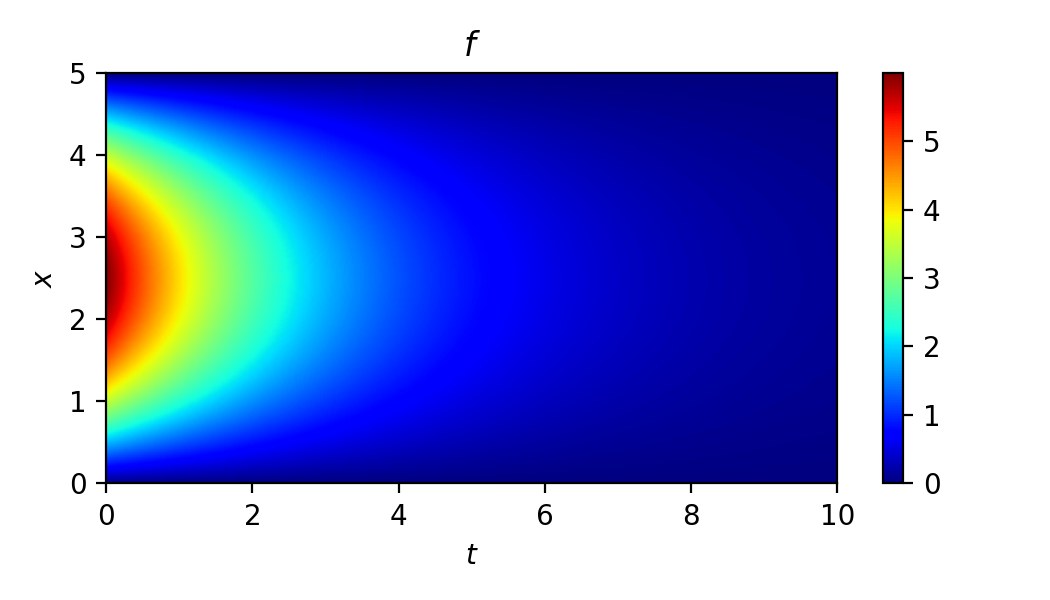

In [65]:
fig = plt.figure(figsize=(3*1.75,3), dpi=200)
ax = fig.subplots()

ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])

# plt.subplots_adjust(bottom=0.17)
plt.subplots_adjust(left=0.17)

ax.set_title('$f$')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')

mesh = ax.pcolormesh(np.reshape(I_sol_star[:, 0], (N_y, -1)), 
               np.reshape(I_sol_star[:, 1], (N_y, -1)), 
               np.reshape(u_pred[:, 0], (N_y, -1)), 
               shading='gouraud',  cmap='jet')

fig.colorbar(mesh)

fig.tight_layout()

# plt.legend()

In [66]:
fig.savefig('../Figures/{name}-{model}.png'.format(
    eqn= __CLASS,
    name= __NAME,
    time= current_time,
    model= model.__class__.__name__
))